In [2]:
import rtde_control
import rtde_receive
import numpy as np
import sys
import yaml
from matplotlib import pyplot as plt
import SimpleITK as sitk
import pickle as pkl


import pyrealsense2 as rs
import cv2
import torch

import time
from collections import deque


from force_control import z_force_control

sys.path.append("../../")

from scripts.SurfaceContact.move import move_default_pose

from scripts.SurfaceContact.control import SurfaceContactControl
from scripts.USImageCV.models.unet import UNet
from scripts.USImageCV.utils.bunny import bunny_mask_predict, load_bunny_model,max_connected_area
%load_ext autoreload
%autoreload 2

# To do Dec 6
- 10 pairs of CT and US comparison images.
- Revert plotting direction in CT visualization.
- Wrap probe control functions into a single file.

# Connect to robot

In [4]:
# from recording_upload_server import CaptureServer

rtde_c = rtde_control.RTDEControlInterface("192.168.1.2")
rtde_r = rtde_receive.RTDEReceiveInterface("192.168.1.2")



# Connect to ultrasound image stream

In [5]:
ultrasoud_vid = cv2.VideoCapture('/dev/video8')

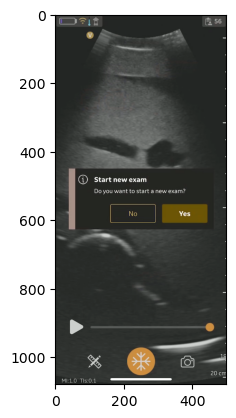

In [6]:

ret, frame = ultrasoud_vid.read()		
plt.imshow(frame)

# Load pre-trained bunny segmentation model

In [6]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

trunk_model = load_bunny_model('../../scripts/USImageCV/model_weights/trunk_seg_model.pth',device)
vessel_model = load_bunny_model('../../scripts/USImageCV/model_weights/vessel_model.pth',device)

# Connect to RGB-D Camera

In [8]:
pipeline = rs.pipeline()
pipeline.start()


# Initialize surface finding controller

In [9]:
with open('../../config/pose_in_TCP_frame.yaml','r') as f:
    poses = yaml.safe_load(f)

    camera_2_tcp = poses['camera']
    probe_2_tcp = poses['probe']
    
body_color_rgb = (99, 55, 34)
body_hsv_rad = (50,50,100)
# rtde_c = rtde_r = []
sc = SurfaceContactControl(pipeline,rtde_c,rtde_r,
                           camera_2_tcp,probe_2_tcp,
                           body_color_rgb,body_hsv_rad)

In [19]:
move_default_pose(rtde_c)

RTDEControlInterface: Could not receive data from robot...
RTDEControlInterface Exception: Operation canceled
RTDEControlInterface: Robot is disconnected, reconnecting...
RTDEReceiveInterface Exception: Operation canceled


Reconnecting...
Dashboard client deadline expired


RTDEControlInterface Exception: Timeout connecting to UR dashboard server.


405 255


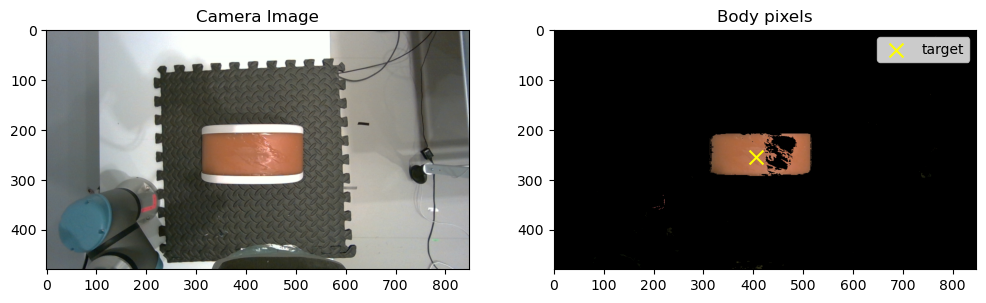

In [12]:
sc.fetchCameraStreamData()
fig = plt.figure(dpi=100,figsize = (12,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sc.showScene([ax1,ax2])


# Utility functions

In [13]:

def find_surface(sc):
    for _ in range(40):
        dist = sc.mainloop()
        dist_threshold = 0.005
        if dist<dist_threshold:
            break
    print("Arrived at above target location. Start descending.")

    sc.loc_normal_control(hover_height=0.20)
    # s = input("Find surface:?")

    if sc.getContact():
        print("Contact made.")

def y_direction_search(model):
    # y direction search has to be very careful, with low speed vel=0.001
    tcp_pose = rtde_r.getActualTCPPose()

    start_pose = rtde_c.poseTrans(tcp_pose,[0,-0.03,0,0,0,0])

    target_pose = rtde_c.poseTrans(tcp_pose,[0,+0.03,0,0,0,0])

    return bunny_view_optim(rtde_c,rtde_r,start_pose,target_pose,
                        ultrasoud_vid,
                        model,device,
                        search_vel = 0.001,
                        search_acc = 0.1)

def x_direction_search(model):
    # x direction search can be more crude, with intermediate speed vel=0.01
    tcp_pose = rtde_r.getActualTCPPose()

    start_pose = rtde_c.poseTrans(tcp_pose,[-0.05,0,0,0,0,0])

    target_pose = rtde_c.poseTrans(tcp_pose,[+0.05,0,0,0,0,0])

    return bunny_view_optim(rtde_c,rtde_r,start_pose,target_pose,
                        ultrasoud_vid,
                        model,device,
                        search_vel = 0.01,
                        search_acc = 0.1)

def bunny_view_optim(rtde_c,rtde_r,start_pose,target_pose,
                     ultrasoud_vid,
                     model,device,
                     search_vel=0.001,
                     search_acc=0.1):
    # Optimize the bunny view by traversing the robot from a start pose to a goal pose.

    # Move the TCP to the starting pose.
    rtde_c.moveL(start_pose,0.01,0.1) 
    
    # After reaching the starting pose, fire off the TCP to move towards the target_pose.
    # Setting asynchoronous=True allows the code to fly forward while the robot execute the motion independently.
    rtde_c.moveL(target_pose,search_vel,search_acc,asynchronous=True) 
    
    # In the asynchorous mode of moveL, we have to actively monitor the robot speed to determine whether the robot has stopped.
    speeds = []
    start_time = time.time()

    time.sleep(0.01) # This will allow the robot to start moving a little
    area_diff = deque(maxlen=3)

    max_area = 0
    optim_pose = []
    frames = []
    for i in range(1000):
        linear_tcp_speed = np.linalg.norm(rtde_r.getActualTCPSpeed()[:3])
        speeds.append(linear_tcp_speed)
        
        ret, frame = ultrasoud_vid.read()	
        frames.append(frame)
        ###### Must record the curr_pose right after the image read and before the neural network inference.
        curr_pose = rtde_r.getActualTCPPose()	
        ######


        mask = bunny_mask_predict(model,frame,device)
        area = max_connected_area(mask)
        # print("area",area,"Time elapsed:",time.time()-start_time)
        area_diff.append(area)
        
        if area>max_area:
            max_area = area
            optim_pose = curr_pose
        
        if len(area_diff)>=3 and\
             np.min(area_diff)>4000 and \
                area_diff[-1]-area_diff[-2]<0 and area_diff[-2]-area_diff[-3]<0:
            # If the area starts to consistently decline, stop the robot. 
            # print(list(area_diff))
            rtde_c.stopL() 
            # We can call stopL() to manually stop the robot during execution.
            # This is very useful pairing with the async move of moveL.

            # And move the robot to the optimal pose
            rtde_c.moveL(optim_pose,0.01,0.1)

            return max_area,frames
        
        if linear_tcp_speed<1e-4:
            return max_area,frames
def find_object(detect_model,area_threshold=5000):
    '''
        detect_model: a neural network that detects the pixels of the object to find.
    '''
    max_a = 0
    while True:
        y_direction_search(detect_model)
        
        a,_ = x_direction_search(detect_model)
        print('Max area',a)
        if a>=max_a:
            max_a = a
        if max_a>=area_threshold:
            break


def centralize_object(model):
    '''
        model: the neural network responsible for outputing the segmentation mask of the desired object.
    '''
    for i in range(20):
        ret, frame = ultrasoud_vid.read()	
        mask = bunny_mask_predict(model,frame,device)
        z_c,x_c=np.mean(np.argwhere(mask),axis=0)

        # We have ensured that the x axis of TCP aligns with axis 1 of frame, and z axis of TCP aligns with axis[0] of frame.
        x_dir = x_c-frame.shape[1]//2
        print("Centralizing the object. Pixel distance remaining: ",np.linalg.norm(x_dir))

        if np.linalg.norm(x_dir)<20:
            break

        tcp_pose = rtde_r.getActualTCPPose()

        move_step = 1/100
        target_pose = rtde_c.poseTrans(tcp_pose,[move_step*np.sign(x_dir),0,0,0,0,0])


        rtde_c.moveL(target_pose,0.005,0.1)
    

def record_registration(record_model,n_samples):
    start_pose = rtde_r.getActualTCPPose()
    frames = []
    poses = []
    
    # Move and record in the feet direction
    target_pose = rtde_c.poseTrans(start_pose,[0,-0.03,0,0,0,0])
    f,p = record_registration_frames(rtde_c,rtde_r,start_pose,target_pose,
                        ultrasoud_vid,
                        record_model,device,
                        n_waypoints = n_samples//2)
    
    # Make sure the order is from feet towards head
    f.reverse()
    p.reverse()

    frames+=f
    poses+=p
    # Move and record in the head direction
    target_pose = rtde_c.poseTrans(start_pose,[0,0.03,0,0,0,0])
    f,p = record_registration_frames(rtde_c,rtde_r,start_pose,target_pose,
                        ultrasoud_vid,
                        record_model,device,
                        n_waypoints = n_samples//2)
    frames+=f
    poses+=p
    return frames,poses
def record_registration_frames(rtde_c,rtde_r,start_pose,target_pose,
                     ultrasoud_vid,
                     model,device,
                    n_waypoints = 50):

    start_loc = start_pose[:3]
    target_loc = target_pose[:3]
    waypoints = np.linspace(start_loc,target_loc,n_waypoints)
    waypoints = [list(w)+start_pose[3:] for w in waypoints]

    rtde_c.moveL(start_pose,0.01,0.1)
    # y direction search has to be very careful, with low speed vel=0.001
    tcp_pose = rtde_r.getActualTCPPose()
    start_pose = tcp_pose

    # In the asynchorous mode of moveL, we have to actively monitor the robot speed to determine whether the robot has stopped.
    speeds = []
    start_time = time.time()

    time.sleep(0.01) # This will allow the robot to start moving a little
    n_hist = 5
    areas = deque(maxlen=n_hist)

    poses=[]
    frames = []
    for w in waypoints:
        
        ret, frame = ultrasoud_vid.read()
        frames.append(frame)
        ###### Must record the curr_pose right after the image read and before the neural network inference.
        curr_pose = rtde_r.getActualTCPPose()	
        poses.append(curr_pose)
        ######
        mask = bunny_mask_predict(model,frame,device)
        area = max_connected_area(mask)
        print("area",area,"Time elapsed:",time.time()-start_time)
        areas.append(area)
        if len(areas)>=n_hist and np.max(areas)<=2000:
            # If the area starts to consistently be small, stop the robot.
            # And move the robot to the start pose
            break
        rtde_c.moveL(w,0.01,0.1)
    rtde_c.moveL(start_pose,0.01,0.1)
    return frames,poses

In [14]:
# Start the control pipeline
move_default_pose(rtde_c)
w0 = rtde_r.getActualTCPForce()# Record force zero

find_surface(sc)

target_force = 22
force_err_tolerance = 0.2
z_force_control(target_force,rtde_r,rtde_c,w0)

find_object(trunk_model)
centralize_object(trunk_model)

f,p = record_registration(vessel_model,n_samples=80)

with open('frames.pkl','wb') as fp:
    pkl.dump({'frames':f,'waypoints':p},fp)

Arrived at above target location. Start descending.
Contact made.


Current force is:22.231617528982024:  Time elapsed=00:12


Target force reached.
Max area 5062.0
Centralizing the object. Pixel distance remaining:  90.63534998967583
Centralizing the object. Pixel distance remaining:  64.69523039611965
Centralizing the object. Pixel distance remaining:  13.738756355103646
area 4531.0 Time elapsed: 0.44836926460266113
area 4527.0 Time elapsed: 0.8466637134552002
area 4495.0 Time elapsed: 1.4854960441589355
area 4496.0 Time elapsed: 2.1420795917510986
area 4052.0 Time elapsed: 2.798755645751953
area 3793.0 Time elapsed: 3.364748239517212
area 3437.0 Time elapsed: 3.990736246109009
area 3113.0 Time elapsed: 4.7402472496032715
area 2989.0 Time elapsed: 5.4060680866241455
area 2929.0 Time elapsed: 6.0417866706848145
area 2801.0 Time elapsed: 6.68907356262207
area 2737.0 Time elapsed: 7.327071189880371
area 2349.0 Time elapsed: 7.974416017532349
area 2081.0 Time elapsed: 8.55810022354126
area 2126.0 Time elapsed: 9.210445404052734
area 2452.0 Time elapsed: 9.868265151977539
area 2505.0 Time elapsed: 10.501643419265

In [14]:
masks = []
for frame in f:
    masks.append(bunny_mask_predict(vessel_model,frame,device))
masks = np.array(masks)

# Get rid of the noisy predictions in the image. Only save the maximal connected component
_,masks = max_connected_area(masks,return_mask=True)

vessel_us = sitk.GetImageFromArray(masks)
with open('../../config/us_spacing.yaml') as fp:
    sp = yaml.safe_load(fp)

# Spacing Units are mm.
xspacing = sp['xspacing'] 
yspacing = sp['yspacing']
start_loc = np.array(p[0][:3])
end_loc = np.array(p[-1][:3])
zspacing = 1000*np.linalg.norm(start_loc-end_loc)/len(f)

vessel_us.SetSpacing((xspacing,yspacing,zspacing))

# Save checkpoint for registration
sitk.WriteImage(vessel_us,'vessel_us.nii.gz')


# 3D Registration between US and CT

In [15]:
from scripts.Registration3D.registration import central_normalize_img, calculate_ct2us_transform
def flip_img(input_img,orders):
    flipped_ct = sitk.Flip(input_img,orders)
    flipped_ct = sitk.GetImageFromArray(sitk.GetArrayFromImage(flipped_ct).astype(np.float64))
    flipped_ct.SetOrigin(input_img.GetOrigin())
    flipped_ct.SetSpacing(input_img.GetSpacing())
    return flipped_ct

In [16]:


original_vessel_ct = sitk.ReadImage('vessel_ct.nii.gz')
# The left-right order is different between the US image and CT image. We flip vessel_ct to make them consistent.
original_vessel_ct = flip_img(original_vessel_ct,[True,False,False])
vessel_ct = central_normalize_img(original_vessel_ct,150)



original_vessel_us = sitk.ReadImage('vessel_us.nii.gz')
vessel_us = central_normalize_img(original_vessel_us,150)

CT2US = calculate_ct2us_transform(vessel_us,vessel_ct)

Start optimizing the transformation


100%|██████████| 10/10 [00:35<00:00,  3.60s/it]


# Visualize registration result

In [17]:

import pickle as pkl
from cv2 import cvtColor

def to_grayscale(img):
    original_shape = img.shape[:2]
    img = cvtColor(img,cv2.COLOR_BGR2GRAY).astype(float)
    img /= np.max(img)
    return img

In [94]:
body_ct = sitk.ReadImage('CT_phantom_regular.nii.gz')
body_ct = flip_img(body_ct,[True,False,False])


with open('frames.pkl','rb') as fp:
    data = pkl.load(fp)
    
frames,waypoints = data['frames'], data['waypoints']
for i in range(len(frames)):
    frames[i] = to_grayscale(frames[i])
body_us = sitk.GetImageFromArray(frames)

CT
1.0 0.0
non invert


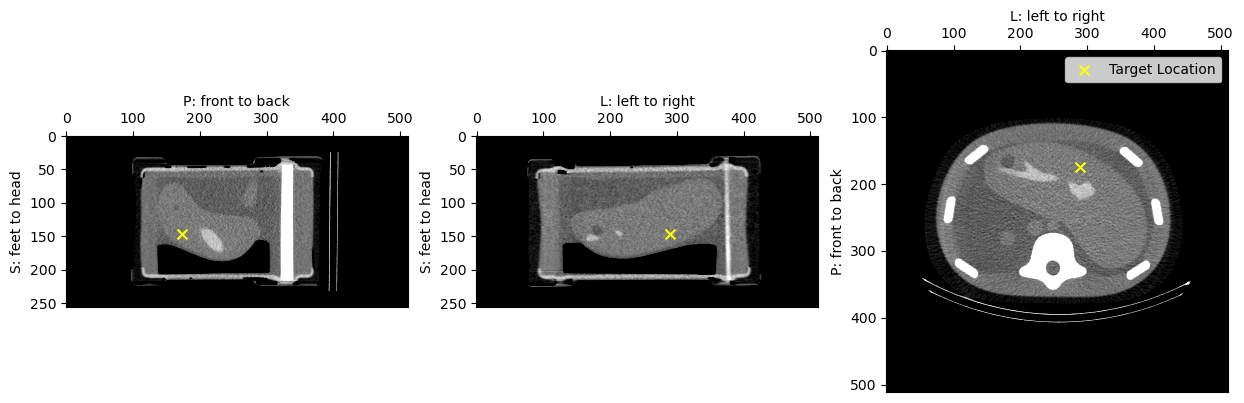

In [91]:
from scripts.Registration3D.registration import visualize_vessel,get_centroid_loc

target_locs = [
                get_centroid_loc(original_vessel_ct) + np.array([5,-20,5]),
                get_centroid_loc(original_vessel_ct) + np.array([5,-20,5]),
               ]



for loc in target_locs:
    pix = original_vessel_ct.TransformPhysicalPointToIndex(loc)
    # visualize_vessel(original_vessel_ct,pix,'Target Location')
    visualize_vessel(body_ct,pix,'Target Location',vmin=0.6,vmax=0.8)

# pix = original_vessel_us.TransformPhysicalPointToIndex(target_loc_us)
# print("Ultrasound")
# visualize_vessel(original_vessel_us,pix,'Estimated Target Location')
# visualize_vessel(body_us,pix,'Estimated Target Location',vmin=0.0,vmax=1.0)



In [ ]:


def move_xy(ref_pos,rtde_r,rtde_c):
    tcp = rtde_r.getActualTCPPose()
    target_pose = ref_pos[:2]+tcp[2:]
    return rtde_c.moveL(target_pose,0.01,0.1)

probe_pos_0 = rtde_c.poseTrans(waypoints[0],sc.probe_2_tcp)
us_origin = rtde_c.poseTrans(probe_pos_0,[-original_vessel_us.GetSpacing()[0]*original_vessel_us.GetSize()[0]/(2*1000),0,0,0,0,0])


## Move to target locations and take ultrasound images
observations = []

for target_loc_ct in target_locs:
    target_loc_us = CT2US.TransformPoint(target_loc_ct)
    tx = -target_loc_us[-1]/1000
    ty = -target_loc_us[0]/1000
    us_x = us_origin[0]
    us_y = us_origin[1]
    target_loc_robot = [us_x+tx,us_y+ty,0,0,0,0]
    move_xy(target_loc_robot,rtde_r,rtde_c)
    ret,frame = ultrasound_vid.read()
    observations.append(frame)


In [34]:
pipeline.stop()

In [35]:
ultrasoud_vid.release()

# Clean up

In [67]:
ultrasoud_vid.release()
pipeline.stop()

# Useful Scripts

In [4]:
# Script for saving default pose
with open('../../config/default_pose.yaml','w') as f:
    yaml.safe_dump({'default_pose':rtde_r.getActualTCPPose()},f)